# Real-Time Stress Detection (Webcam Demo)

This notebook demonstrates a real-time Computer Vision pipeline
that estimates a Stress Index (0–100) by fusing:

- Physiological signal (rPPG variability)
- Behavioral signal (head motion)

The goal is to validate system behavior under:
- Calm conditions
- Induced stress (typing, mental arithmetic, movement)

This notebook uses the same modular logic as the production code.


In [6]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)


import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

from src.video import VideoStream
from src.landmarks import FaceLandmarkDetector
from src.rppg import RPPGExtractor
from src.behavior import HeadMotionAnalyzer
from src.fusion import StressFusion
from src.visualizer import Visualizer


In [7]:
!cd '/home/nilgiri/my-project/'

In [8]:
# !mkdir -p models
# !wget https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/latest/face_landmarker.task \
#      -O models/face_landmarker.task


In [9]:
# Video source (0 = default webcam)
video = VideoStream(src=0)

# Core CV modules
landmarker = FaceLandmarkDetector()
rppg = RPPGExtractor(fs=30)
motion = HeadMotionAnalyzer(window=30)
fusion = StressFusion(alpha=0.2)
viz = Visualizer()

print("Pipeline initialized successfully.")


Pipeline initialized successfully.


[ WARN:0@42.698] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@42.700] global obsensor_uvc_stream_channel.cpp:163 getStreamChannelGroup Camera index out of range
I0000 00:00:1766694123.371360  774699 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1766694123.418857  774832 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 560.35.03), renderer: NVIDIA GeForce GTX 1080 Ti/PCIe/SSE2
W0000 00:00:1766694123.419254  774699 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


In [10]:
def extract_roi_signal(frame, landmarks):
    """
    Extract a coarse physiological signal from the face.

    For demo purposes:
    - Uses mean pixel intensity over the entire frame
    - Keeps logic transparent and robust

    This can be replaced with a tighter facial ROI if desired.
    """
    return frame.mean()


In [11]:
stress_history = []
time_history = []

start_time = time.time()

print("Starting webcam demo. Press ESC to exit.")

while True:
    frame, ts = video.read()
    if frame is None:
        break

    timestamp_ms = int((ts - start_time) * 1000)

    # Detect facial landmarks
    landmarks = landmarker.detect(frame, timestamp_ms)

    if landmarks is not None:
        # Behavioral signal
        motion.update(landmarks)

        # Physiological signal
        roi_signal = extract_roi_signal(frame, landmarks)
        rppg.add_frame(roi_signal)

    # Fuse signals into stress index
    stress = fusion.update(
        hr_var=rppg.get_hr_variability(),
        motion=motion.motion_energy()
    )

    stress_history.append(stress)
    time_history.append(ts - start_time)

    # Visualization overlay
    frame = viz.draw(frame, stress)

    cv2.imshow("Stress Detection Demo", frame)

    if cv2.waitKey(1) & 0xFF == 27:  # ESC
        break

video.release()
cv2.destroyAllWindows()

print("Demo stopped.")


Starting webcam demo. Press ESC to exit.
Demo stopped.


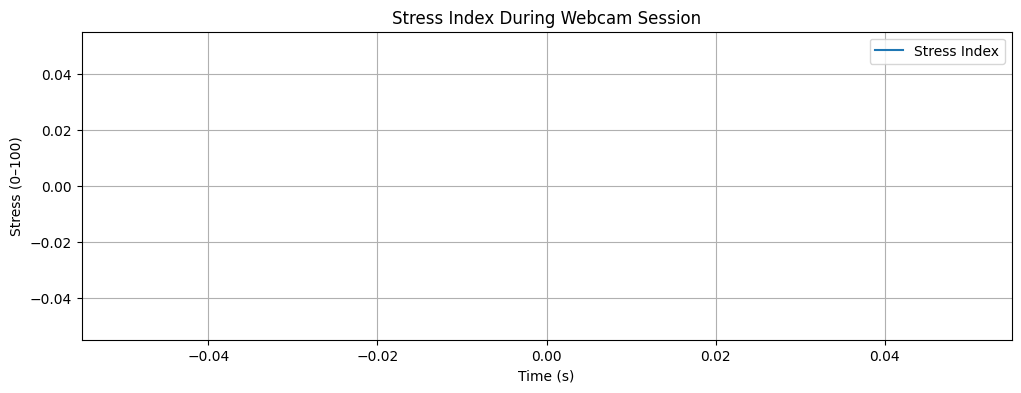

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(time_history, stress_history, label="Stress Index")
plt.xlabel("Time (s)")
plt.ylabel("Stress (0–100)")
plt.title("Stress Index During Webcam Session")
plt.legend()
plt.grid(True)
plt.show()
